<a href="https://colab.research.google.com/github/venkateshakula1729/GenAI-Fusion/blob/main/Finetuning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Web scraping Jokes from wocka


In [ ]:
from lxml import html
import requests
import json
import logging

logging.basicConfig(level=logging.ERROR)

def extract_joke(id):
    """Download and parse a single joke."""

    url_base = "http://www.wocka.com/{}.html"
    response = requests.get(url_base.format(id))

    tree = html.fromstring(response.content)
    content = tree.xpath('//div[@id="content"]')[0]
    h2s = tree.xpath('//div[@id="content"]/h2')
    category_rows = content.xpath('./div[@class="right"]//tr/td/b[text()="Category"]/../..')

    crap = tree.xpath('//div[@id="content"]/child::node()[not(self::text()) and not(self::br)]') # all html nodes in content, but not plaintext

    for node in crap:
        content.remove(node)

    body_text = content.text_content().strip()

    if body_text == "This joke does not exist":
        return None, "does not exist", None
    if body_text == "This is a dirty joke, so it has been hidden.  To read this joke, you will need to create an account and signin.":
        return None, "is dirty", None

    category = category_rows[0].xpath('./td/a/text()')[0]

    title = h2s[0]
    joke_title = title.text_content()
    joke_body = body_text

    return joke_title, joke_body, category


if __name__ == "__main__":

    jokes = []

    save_frequency = 100 # save after every 100 IDs
    max_id = 19000
    for id in range(1, max_id+1): #19000
        try:
            title, body, category = extract_joke(id)

            if title is None:
              #  print("ID {} {}.".format(id, body))
                continue

            joke = {"id": id, "category": category, "title": title, "body": body}
            jokes.append(joke)
           # print("ID {} success: [{}] {}".format(id, category, title))
        except Exception as ex:
           # print("ID {} failed: ".format(id))
            logging.error(ex)

        if id % save_frequency == 0 or id == max_id:
            with open("jokes.json", "w") as f:
                json.dump(jokes, f, indent=4, sort_keys=True)

### Import Libraries and Setup


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from tqdm import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Data Loading and Initial Exploration

In [ ]:
def load_and_explore_data(file_path):
    # Load the dataset
    with open('jokes.json', 'r') as file:
        jokes_data = json.load(file)

    # Convert to DataFrame
    df = pd.DataFrame(jokes_data)

    # Basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Number of jokes: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")
    print(f"Columns: {', '.join(df.columns)}")
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nSample Joke:")
    print(df.iloc[0])

    return df

# Load the data
df = load_and_explore_data('jokes.json')

Dataset Overview:
--------------------------------------------------
Number of jokes: 10019
Number of columns: 4
Columns: body, category, id, title

Missing Values:
body        0
category    0
id          0
title       0
dtype: int64

Sample Joke:
body        What do you call a cow with no legs?\r\n\r\nGr...
category                                               Animal
id                                                          1
title                                        Cow With No Legs
Name: 0, dtype: object


### Text Preprocessing and Tokenization

In [ ]:

from transformers import GPT2Tokenizer

class JokeTokenizer:
    def __init__(self):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        # Add padding token to GPT2 tokenizer
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def clean_text(self, text):
        """Basic text cleaning"""
        text = str(text).strip()
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
        return text

    def tokenize_text(self, text, max_length=128):
        """Tokenize text using GPT2 tokenizer"""
        cleaned_text = self.clean_text(text)

        # Tokenize with padding and truncation
        encoded = self.tokenizer(
            cleaned_text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze()
        }

    def decode_tokens(self, token_ids):
        """Decode token IDs back to text"""
        return self.tokenizer.decode(token_ids)

# Initialize tokenizer and process texts
joke_tokenizer = JokeTokenizer()

# Add tokenized data to DataFrame
print("Tokenizing jokes...")
tokenized_data = [joke_tokenizer.tokenize_text(text) for text in tqdm(df['body'])]
df['input_ids'] = [d['input_ids'] for d in tokenized_data]
df['attention_mask'] = [d['attention_mask'] for d in tokenized_data]

# Show sample tokenization
sample_joke = df['body'].iloc[0]
sample_tokens = joke_tokenizer.tokenizer.tokenize(sample_joke)
print("\nSample Tokenization:")
print("Original:", sample_joke)
print("Tokens:", sample_tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Tokenizing jokes...


  0%|          | 0/10019 [00:00<?, ?it/s]


Sample Tokenization:
Original: What do you call a cow with no legs?

Ground Beef!
Tokens: ['What', 'Ġdo', 'Ġyou', 'Ġcall', 'Ġa', 'Ġcow', 'Ġwith', 'Ġno', 'Ġlegs', '?', 'č', 'Ċ', 'č', 'Ċ', 'Ground', 'ĠBeef', '!']


### Basic Statistical Analysis


In [ ]:
def perform_statistical_analysis(df):
    # Length statistics
    df['original_length'] = df['body'].str.len()
    df['cleaned_length'] = df['cleaned_body'].str.len()
    df['word_count'] = df['cleaned_body'].str.split().str.len()

    print("Text Length Statistics:")
    print("-" * 50)
    print("\nOriginal Text:")
    print(df['original_length'].describe())
    print("\nCleaned Text:")
    print(df['cleaned_length'].describe())
    print("\nWord Count:")
    print(df['word_count'].describe())

    return df

df = perform_statistical_analysis(df)

Text Length Statistics:
--------------------------------------------------

Original Text:
count    10019.000000
mean       619.665336
std       1353.567013
min          0.000000
25%         96.000000
50%        317.000000
75%        751.000000
max      63251.000000
Name: original_length, dtype: float64

Cleaned Text:
count    10019.000000
mean       365.062980
std        864.528804
min          0.000000
25%         53.000000
50%        183.000000
75%        434.000000
max      40774.000000
Name: cleaned_length, dtype: float64

Word Count:
count    10019.000000
mean        56.543767
std        127.740883
min          0.000000
25%          9.000000
50%         29.000000
75%         68.000000
max       5928.000000
Name: word_count, dtype: float64


### Token Analysis


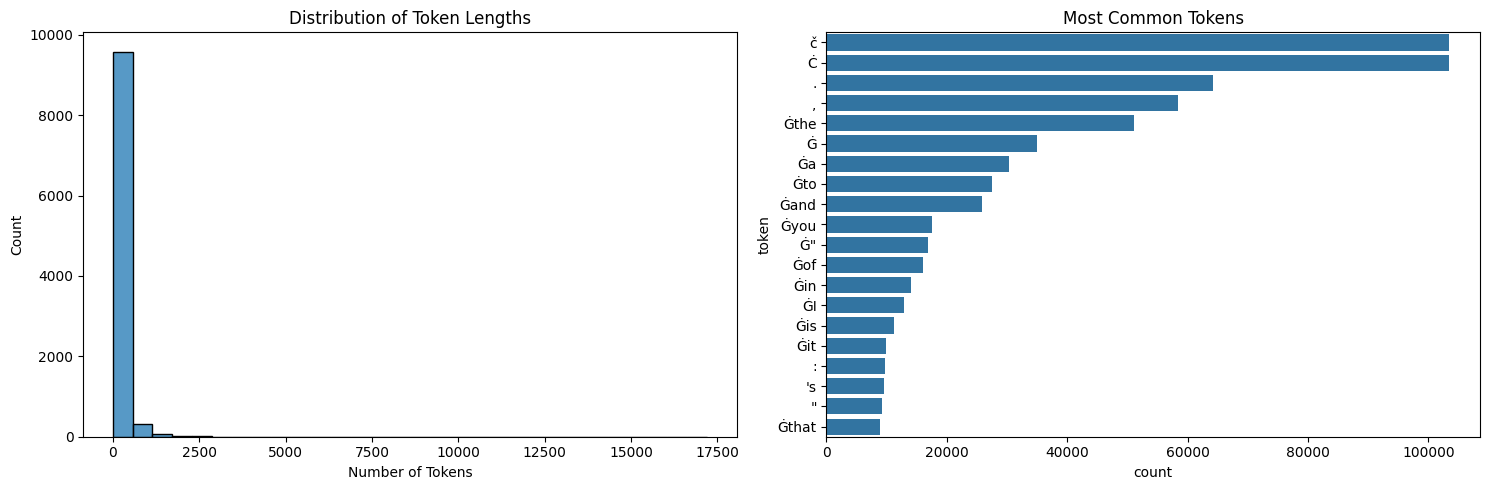

In [ ]:
def analyze_tokens(df, joke_tokenizer):
    # Get token statistics
    token_lengths = [len(joke_tokenizer.tokenizer.tokenize(text)) for text in df['body']]

    plt.figure(figsize=(15, 5))

    # Token length distribution
    plt.subplot(1, 2, 1)
    sns.histplot(token_lengths, bins=30)
    plt.title('Distribution of Token Lengths')
    plt.xlabel('Number of Tokens')

    # Most common tokens
    all_tokens = []
    for text in df['body']:
        all_tokens.extend(joke_tokenizer.tokenizer.tokenize(text))
    token_freq = Counter(all_tokens).most_common(20)

    plt.subplot(1, 2, 2)
    token_df = pd.DataFrame(token_freq, columns=['token', 'count'])
    sns.barplot(data=token_df, x='count', y='token')
    plt.title('Most Common Tokens')

    plt.tight_layout()
    plt.show()

    return token_freq

token_frequencies = analyze_tokens(df, joke_tokenizer)

### Category Analysis


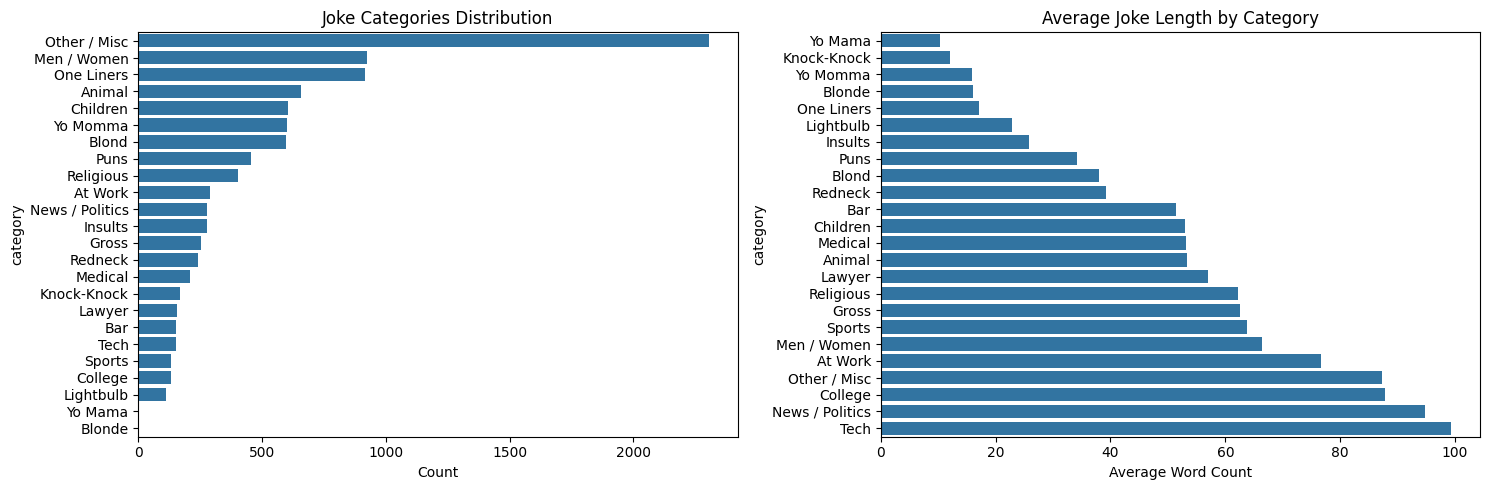

In [ ]:
def plot_category_analysis(df):
    plt.figure(figsize=(15, 5))

    # Category distribution
    plt.subplot(1, 2, 1)
    sns.countplot(y=df['category'], order=df['category'].value_counts().index)
    plt.title('Joke Categories Distribution')
    plt.xlabel('Count')

    # Average joke length by category
    plt.subplot(1, 2, 2)
    avg_length = df.groupby('category')['word_count'].mean().sort_values(ascending=True)
    sns.barplot(x=avg_length.values, y=avg_length.index)
    plt.title('Average Joke Length by Category')
    plt.xlabel('Average Word Count')

    plt.tight_layout()
    plt.show()

plot_category_analysis(df)

### Word Analysis and Visualization


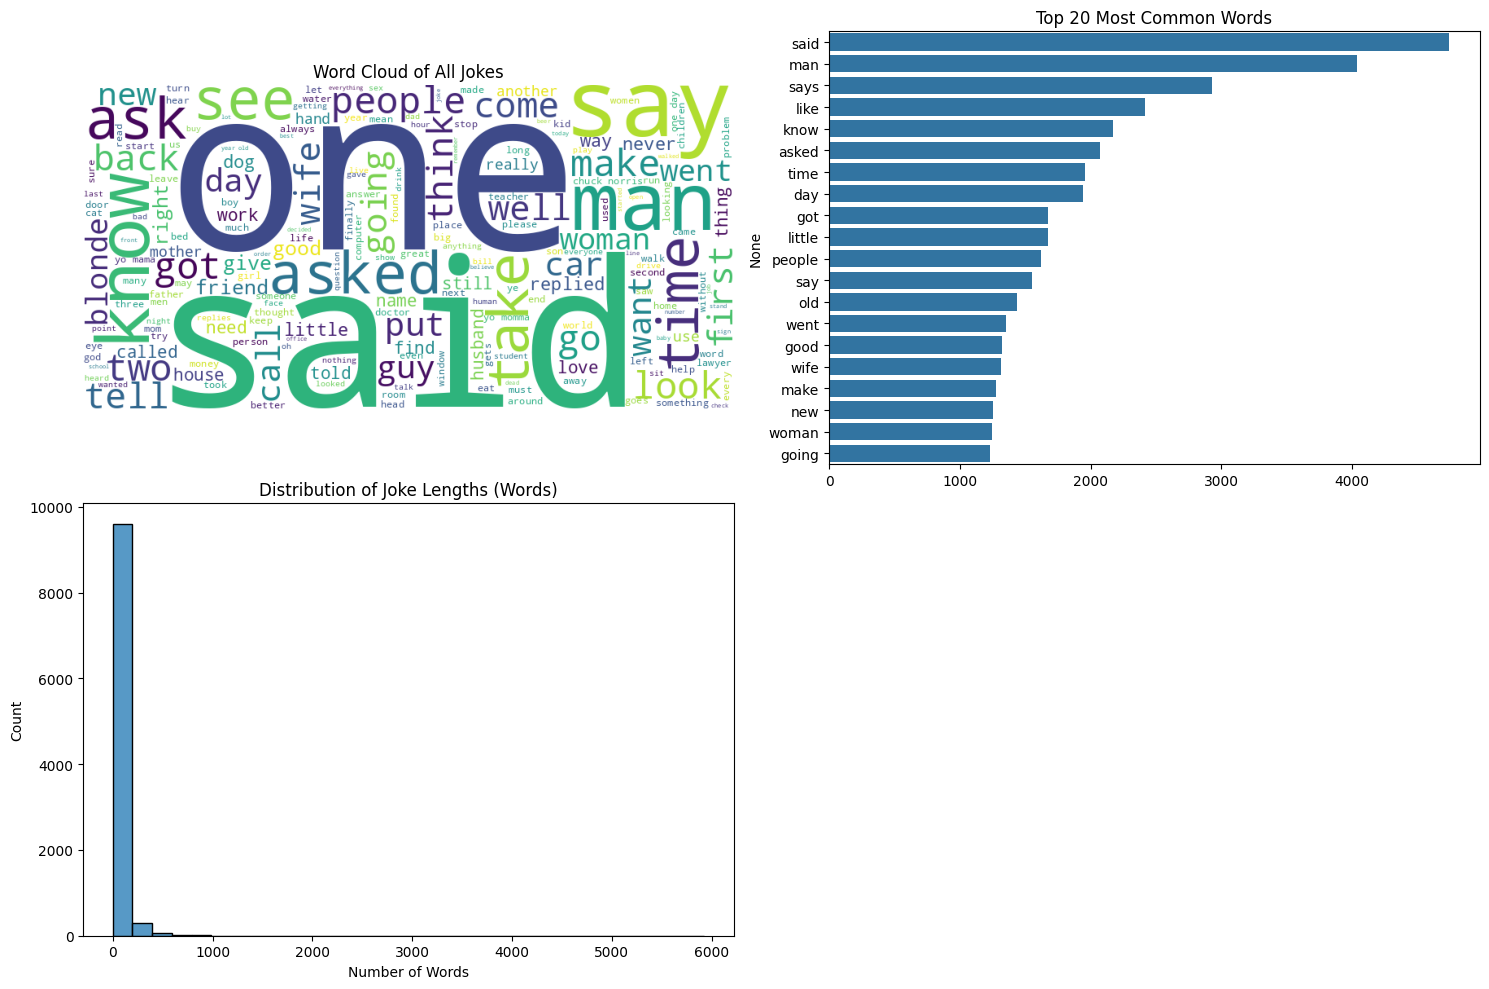

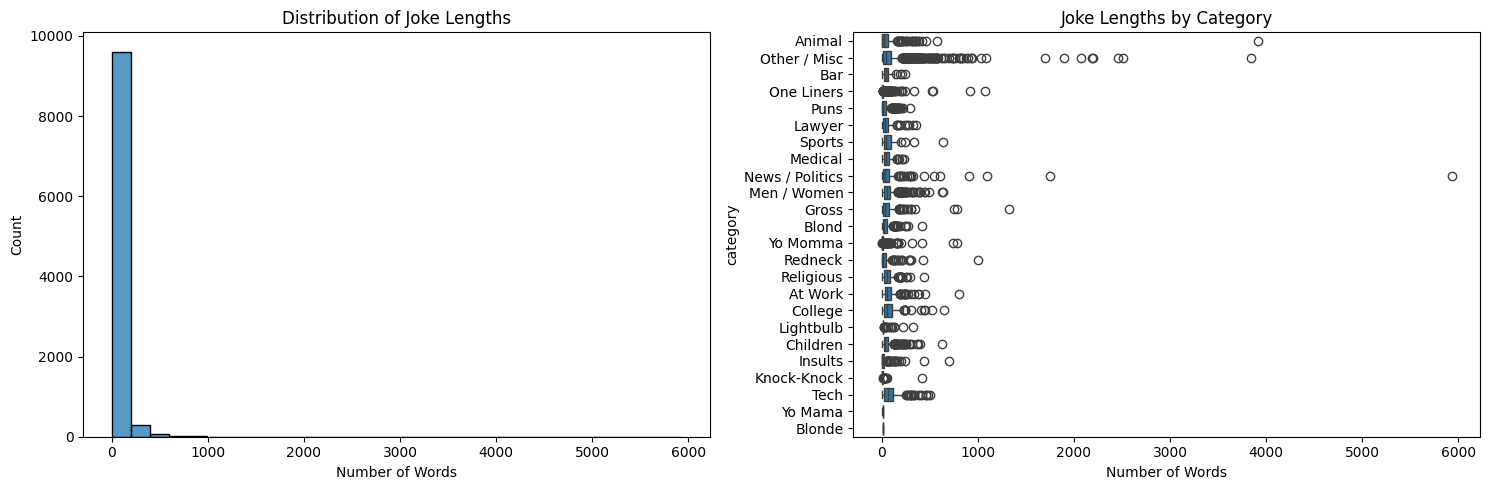

In [ ]:
def analyze_vocabulary(df):
    # Create word frequency distribution
    vectorizer = CountVectorizer(stop_words='english')
    word_freq = vectorizer.fit_transform(df['cleaned_body'])
    word_freq_df = pd.DataFrame(word_freq.toarray(), columns=vectorizer.get_feature_names_out())

    # Word cloud
    plt.figure(figsize=(15, 10))

    # Overall word cloud
    plt.subplot(2, 2, 1)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_body']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of All Jokes')

    # Top words bar plot
    plt.subplot(2, 2, 2)
    word_sums = word_freq_df.sum().sort_values(ascending=False)[:20]
    sns.barplot(x=word_sums.values, y=word_sums.index)
    plt.title('Top 20 Most Common Words')

    # Word frequency distribution
    plt.subplot(2, 2, 3)
    word_lengths = df['cleaned_body'].str.split().apply(len)
    sns.histplot(word_lengths, bins=30)
    plt.title('Distribution of Joke Lengths (Words)')
    plt.xlabel('Number of Words')

    plt.tight_layout()
    plt.show()

    return word_freq_df

word_freq_df = analyze_vocabulary(df)
# Section 7: Length Analysis
def analyze_joke_lengths(df):
    plt.figure(figsize=(15, 5))

    # Distribution of joke lengths
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='word_count', bins=30)
    plt.title('Distribution of Joke Lengths')
    plt.xlabel('Number of Words')

    # Box plot of lengths by category
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='word_count', y='category')
    plt.title('Joke Lengths by Category')
    plt.xlabel('Number of Words')

    plt.tight_layout()
    plt.show()

analyze_joke_lengths(df)

In [ ]:
# Save Processed Data
def save_processed_data(df):
    # Save main DataFrame
    df.to_csv('processed_jokes.csv', index=False)

    # Save vocabulary statistics
    word_stats = pd.DataFrame({
        'word_count': word_freq_df.sum().sort_values(ascending=False),
        'document_frequency': (word_freq_df > 0).sum().sort_values(ascending=False)
    })
    word_stats.to_csv('word_statistics.csv')

    print("Files saved successfully!")
    print(f"Total vocabulary size: {len(word_stats)}")
save_processed_data(df)

Files saved successfully!
Total vocabulary size: 35649
